# PDE-FIND for the Kuramoto Sivashinsky Equation

This notebook demonstrates PDE-FIND on the Kuramoto Sivashinsky equation.
$$
u_t + u_{xxxx} + uu_x + u_{xx} = 0
$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd

import sys; sys.path.append('../')
from PDE_FIND import *

import os
import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter, butter, filtfilt, wiener
from scipy import integrate
from scipy.integrate import simpson, trapz, romb
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

def evaluate_coefficients(prediected_coeffs):
    assert len(prediected_coeffs.flatten()) == 3
    errs = 100*np.abs(prediected_coeffs.flatten()+1)
    return errs.mean(), errs.std()

def percent_coeff(pred, ground):
    return 100*np.abs(pred-ground)/np.abs(ground)

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

import derivative
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise
from functools import partial
from findiff import FinDiff

from tqdm import tqdm, trange
from tsmoothie.smoother import *

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
data = sio.loadmat('../Datasets/kuramoto_sivishinky.mat')
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

assert np.max(x)/32 == np.pi

In [3]:
np.random.seed(0)
noise_lv = 30
un = u + 0.01*noise_lv*u.std()*np.random.randn(u.shape[0],u.shape[1])

In [4]:
# un = np.load("./denoised_u_files/KS_noise30_reduced_dctksvdreg.npy")
# un = np.load("./denoised_u_files/KS_noise30_reduced_dctV2ksvdreg_21x21.npy")
un = np.load("./denoised_u_files/KS_noise30_reduced_dctV2ksvdreg_25x25.npy")

In [5]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = -0.994 x0_11 + -0.996 x0_1111 + -0.992 x0x0_1


In [6]:
class Differentiator(ps.BaseDifferentiation):
    def __init__(self, diff_name, diff_func_kwargs, 
                 d=1, axis=1, 
                 is_uniform=True, periodic=False):
        super(Differentiator, self).__init__()
        self.diff_name = diff_name
        self.diff_func_kwargs = diff_func_kwargs
        self.diff_func = getattr(derivative, self.diff_name)(**diff_func_kwargs)
        
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        self.transform = np.vectorize(composite_function(self.diff, lambda _: _, left2right=True), signature="(m),(m)->(m)")

    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                diff = self.transform(x[:,:,i].T, t).T
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                diff = self.transform(x[:,:,i], t)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)

class FiniteDifferentiator(ps.BaseDifferentiation):
    def __init__(self, acc=2, d=1, axis=1, is_uniform=True, periodic=False):
        super(FiniteDifferentiator, self).__init__()        
        self.acc = acc
        self.d = d
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
    def _differentiate(self, x, t):
        if self.is_uniform:
            if isinstance(t, float): 
                dt = t
            else: 
                dt = t[1]-t[0]
            self.diff = FinDiff(self.axis, dt, self.d, acc=self.acc)
        else:
            raise NotImplementedError("is_uniform=False")
            self.diff = FinDiff(self.axis, self.d, acc=self.acc)
        return self.diff(x)

In [7]:
### originally from derivative ###
## slow ##
# diff_name, diff_func_kwargs = "Kalman", {'alpha':kalpha}
## fast ##
# diff_name, diff_func_kwargs = "FiniteDifference", {'k':1}
# differentiation_method = Differentiator
# differentiation_kwargs = {"diff_name": diff_name, "diff_func_kwargs": diff_func_kwargs}

# originally from pysindy
# differentiation_method, differentiation_kwargs = ps.SmoothedFiniteDifference, {}

# originally from findiff (accurate and fast)
differentiation_method, differentiation_kwargs = FiniteDifferentiator, {'acc':4}

In [8]:
diff_order = 4
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=4, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}

In [9]:
# optimizer = BruteForceRegressor(3)
# if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=4, lam=5e-2, is_normal=True, normalize_columns=False, threshold=1e-4)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=3, alpha=5e-2, normalize_columns=False, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method(**differentiation_kwargs), 
                 cache=True,
                 feature_names=['u'])

In [10]:
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
model.get_feature_names()

X_pre, y_pre = np.squeeze(model.feature_library.cached_xp_full), model.cached_x_dot
# print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

Set parameter Username


2023-08-17 19:34:01,744 [INFO] Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-04


2023-08-17 19:34:01,748 [INFO] Academic license - for non-commercial use only - expires 2024-06-04


In [11]:
def hierarchy(fitted_model, dataset, target_index=0, field=0):
    Xd, yd = dataset
    yd = yd[:, target_index]
    model_results = {}
    for effective_indices in fitted_model:
        com = len(effective_indices)
        X_pre_sup = Xd[:, effective_indices]
        solve = np.linalg.lstsq(X_pre_sup, yd, rcond=None)
        coeff = solve[0]
        if len(solve[1]) == 1:
            mse = solve[1][0]
            if (com not in model_results) or model_results[com][-1] > mse:
                model_results[com] = effective_indices, coeff, mse
    if field < 0: 
        return model_results
    else: 
        dkeys = model_results.keys()
        dvals = (lambda lst, _: [t[_] for t in lst if len(t)>_])(model_results.values(), field)
        return dict(zip(dkeys, dvals))

def hierarchy_sindy(fitted_model, dataset, target_index=0):
    Xd, yd = dataset
    target_index = 0
    model_results = {}
    model_coef_array = np.array(fitted_model.get_coef_list())[:, target_index, :].T
    # mses = (((Xd@(model_coef_array))-yd)**2).mean(axis=0)
    eff = np.apply_along_axis(lambda arr: np.where(arr != 0, 1, arr), 
                              axis=-1, arr=model_coef_array).T

    for i in range(eff.shape[0]-1):
        effective_indices = tuple(np.where(eff[i]>0)[0])
        X_pre_sup = Xd[:, effective_indices]
        com = len(effective_indices)

        solve = np.linalg.lstsq(X_pre_sup, yd, rcond=None)
        coeff = solve[0]
        # mse = ((X_pre_sup@coeff-yd)**2).mean()
        if len(solve[1]) == 1:
            mse = solve[1][0]
            if (com not in model_results) or model_results[com][-1] > mse:
                model_results[com] = effective_indices, coeff, mse

    return model_results

In [12]:
model_results = hierarchy_sindy(model, (X_pre, y_pre))
model_results

{3: ((3, 5, 6),
  array([[-0.99514305],
         [-0.99660169],
         [-0.99681542]]),
  155.3733557070583)}

In [13]:
(np.abs(model_results[3][1]+1)*100).mean() # 0.38132791930786114

0.38132791930786114

In [14]:
optimizer_name = "miosr" # "l0bnb", "miosr"
print(optimizer_name)
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
n_ensemble_models = 50; miosr_alpha = 5e-2
all_eff_rhs = []
for mnz in range(1, 9):
    print(mnz)    
    if optimizer_name == "l0bnb":
        optimizer = L0BNB(max_nonzeros=mnz, lam=5e-2, is_normal=True, normalize_columns=False, threshold=1e-4)
    elif optimizer_name == "miosr":
        optimizer = ps.MIOSR(target_sparsity=mnz, alpha=5e-2, normalize_columns=False, regression_timeout=100)
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=differentiation_method(**differentiation_kwargs), 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    
    # ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    # all_eff_rhs.append(eff_rhs_indices)
    all_eff_rhs.extend([v[0] for v in hierarchy_sindy(model, (X_pre, y_pre)).values()])

miosr
1
2
3
4
5
6
7
8


In [15]:
print("From leaps")
Rdata_name = "leaps/leaps_efi_nbest40.npy"
leaps_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/KS", Rdata_name))
leaps_best_subsets = [tuple(np.where(bs>0)[0]) for bs in leaps_best_subsets]
leaps_best_subsets = sorted(hierarchy(leaps_best_subsets, (X_pre, y_pre)).values(), key=len)
leaps_best_subsets = [e[0] for e in backward_refinement(leaps_best_subsets, (X_pre, y_pre), 
                                                        mode='SelectKBest', ic_type='bic', 
                                                        verbose=False).track.values()]
leaps_best_subsets

From leaps


[(6,),
 (6, 9),
 (3, 5, 6),
 (3, 4, 5, 6),
 (0, 3, 5, 6, 13),
 (0, 3, 5, 6, 10, 13),
 (0, 3, 5, 6, 9, 10, 13),
 (0, 1, 3, 4, 5, 6, 8, 13),
 (0, 1, 3, 4, 5, 6, 8, 12, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 10, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

In [16]:
print("From imsubsets")
Rdata_name = "imsubsets/imsubsets_efi.npy"
imsubsets_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/KS", Rdata_name))
imsubsets_best_subsets = [tuple(np.where(bs>0)[0]) for bs in imsubsets_best_subsets]
imsubsets_best_subsets = sorted(hierarchy(imsubsets_best_subsets, (X_pre, y_pre)).values(), key=len)
imsubsets_best_subsets = [e[0] for e in backward_refinement(imsubsets_best_subsets, (X_pre, y_pre), 
                                                            mode='SelectKBest', ic_type='bic', 
                                                            verbose=False).track.values()]
imsubsets_best_subsets

From imsubsets


[(6,),
 (6, 9),
 (3, 5, 6),
 (3, 4, 5, 6),
 (0, 3, 5, 6, 13),
 (0, 3, 5, 6, 10, 13),
 (0, 3, 5, 6, 9, 10, 13),
 (0, 1, 3, 4, 5, 6, 8, 13),
 (0, 1, 3, 4, 5, 6, 8, 12, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 10, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

In [17]:
print("From brute-force solver")
brute_best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0])
                      for i in range(1, X_pre.shape[1]+1)]
brute_best_subsets
brute_best_subsets

From brute-force solver


[(6,),
 (6, 9),
 (3, 5, 6),
 (3, 4, 5, 6),
 (0, 3, 5, 6, 13),
 (0, 3, 5, 6, 10, 13),
 (0, 3, 5, 6, 9, 10, 13),
 (0, 1, 3, 4, 5, 6, 8, 13),
 (0, 1, 3, 4, 5, 6, 8, 12, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 10, 13),
 (0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

In [18]:
print("Leaps in R package got wrong!?")
for leaps_indices, imsubsets_indices, brute_indices in zip(leaps_best_subsets, imsubsets_best_subsets, brute_best_subsets):
    if (leaps_indices != brute_indices) or (leaps_indices != brute_indices):
        print(leaps_indices, brute_indices)

Leaps in R package got wrong!?


In [19]:
all_eff_rhs.append(tuple(i for i in range(X_pre.shape[1])))
all_eff_rhs.extend(brute_best_subsets)

In [20]:
mode = 'rfe'; ic_type = 'bic'
st = backward_refinement(all_eff_rhs, (X_pre, y_pre), 
                         mode=mode, ic_type=ic_type, verbose=False)
st += backward_refinement(all_eff_rhs, (normalize(X_pre, axis=0), y_pre), 
                          mode=mode, ic_type=ic_type, verbose=False)

In [21]:
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    print(indices, aic)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
    # print(decreasing_aics, complexities)
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)

(6,) 30294.799676276198
(6, 9) 25206.589349153135
(3, 5, 6) -13238.692449745493
(3, 4, 5, 6) -13231.763926646281
(0, 3, 5, 6, 13) -13234.62474464353
(0, 3, 5, 6, 10, 13) -13228.432854216615
(0, 3, 5, 6, 9, 10, 13) -13223.532618664593
(0, 1, 3, 4, 5, 6, 8, 13) -13222.734217826408
(0, 1, 3, 4, 5, 6, 8, 12, 13) -13216.732358060819
(0, 1, 3, 4, 5, 6, 8, 9, 10, 13) -13211.959433027778
(0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 13) -13206.139074637053
(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13) -13197.26985935631
(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13) -13188.163632617596
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13) -13178.956138410147


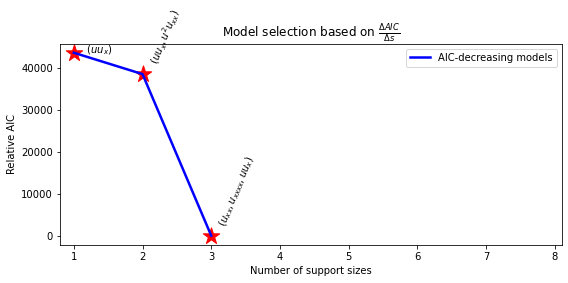

In [22]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="AIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta AIC}{\Delta s}$")
plt.ylabel("Relative AIC")
plt.xlabel("Number of support sizes")
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
good_coms = set()
min_pok = 0.01
max_pok = 1.
delta_pok = min_pok
for p in np.arange(min_pok, max_pok+delta_pok, delta_pok):
    c = find_transition_V5(decreasing_aics, complexities, percent_ok=p)
    if c == 1: break
    good_coms.add(c)
good_coms

3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.525207606089329
3 improves 2
Percent improve: 1.52520760

{3}

In [24]:
# w/o denoise: -43121.383119584396
# w/ denoise: -43533.492126021694
print(decreasing_aics[1]-decreasing_aics[0])
print(min(decreasing_aics)-max(decreasing_aics))
decreasing_aics, complexities, eff_feature_names

-5088.210327123063
-43533.492126021694


(array([ 30294.79967628,  25206.58934915, -13238.69244975]),
 array([1, 2, 3]),
 [['uu_{x}'], ['uu_{x}', 'u^2u_{xx}'], ['u_{xx}', 'u_{xxxx}', 'uu_{x}']])

In [25]:
errs = percent_coeff(np.linalg.lstsq(X_pre[:, (3, 5, 6)], y_pre, rcond=None)[0], -1)
errs.mean(), errs.std()

(0.38132791930786114, 0.07431246710249238)

In [26]:
brute_com = 4
brute_coeff = brute_force(X_pre, y_pre, support_size=4).flatten()
brute_indices = np.where(brute_coeff!=0)[0]
# [-0.99520256, 6.3890000e-04, -0.99665364, -0.99689419]
np.array(list(map(convert2latex, model.get_feature_names())))[brute_indices], brute_coeff[brute_indices]

(array(['u_{xx}', 'u_{xxx}', 'u_{xxxx}', 'uu_{x}'], dtype='<U11'),
 array([-9.95202555e-01,  6.38896462e-04, -9.96653643e-01, -9.96894189e-01]))

#### Model selection

In [27]:
# Use PDE_FIND_Loss from parametric_pde_find.py by formulating as a parametric problem
# Moving horizon in time

def ssr2llf(ssr, nobs):
    nobs2 = nobs / 2.0
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    ssr = np.sum(np.abs(ground - prediction)**2)
    return ssr2llf(ssr, nobs)

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

def AIC_Loss(A,b,x,epsilon=1e-5):
    N = A.shape[0]
    k = np.count_nonzero(x)
    # Rudy et al., 2019
    rss = ((b-A.dot(x))**2).sum()
    aic = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
    return aic

def PDE_FIND_Loss(As,bs,x,epsilon=1e-5,const_coeff=True,cv=0,ic_type="bic",version=0):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    
    rss = [np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)]
    rss = np.sum(rss)
    llf = ssr2llf(rss, N)
    
    k = np.count_nonzero(x)
    if const_coeff:
        k = np.count_nonzero(x)/m
    k = k + k*cv
    
    if ic_type == "aic":
        aic1 = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
        aic2 = -2*llf + 2*k + (2*k**2+2*k)/(N-k-1)
        if version > 0:
            return aic2
        return aic1
    elif ic_type == "bic":
        bic1 = N*np.log(rss/N+epsilon) + np.log(N)*k
        bic2 = -2*llf + np.log(N)*k
        if version > 0:
            return bic2
        return bic1

[4.97280248 5.49060432 3.5783858  4.0036682  4.1716285  5.29149594
 5.82871027 5.17086079 5.27474051 6.82687014 6.93764398 7.97494687
 8.487246   9.65857599]
2,2,2,2,2,2,2,2,2,

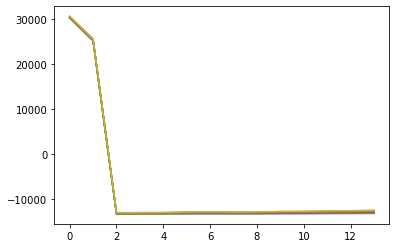

In [28]:
baye_alpha = 1e-6
mul_val = 1
brr_uncertainties = []
brr_bics = []
for com in sorted(st.track.keys()):
    brr = BayesianRidge(compute_score=True, alpha_1=baye_alpha, alpha_2=baye_alpha)
    brr.fit(X_pre[:, st.track[com][0]], y_pre)
    uncert = mul_val*np.trace(np.sqrt(brr.sigma_))
    brr_uncertainties.append(uncert)
    brr_bics.append((brr.predict(X_pre[:, st.track[com][0]]).reshape(-1, 1), 
                     np.count_nonzero(brr.coef_), 
                     uncert))
brr_uncertainties = np.array(brr_uncertainties)

power = 0
while 1:
    e = brr_uncertainties.min()*(10**power)
    if e > 1: break
    power += 1
mul_val = 10**power
brr_uncertainties = brr_uncertainties*mul_val
print(brr_uncertainties)

for kkk in range(1, 10):
    brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+kkk*mul_val*brr_uncert)[0] 
                   for brr_pred, brr_com, brr_uncert in brr_bics]
    print(np.argmin(brr_bicaics), end=',')
    plt.plot(brr_bicaics)
plt.show()

In [29]:
from UBIC import *

In [30]:
best_subsets = sorted([indices for _, (indices, _) in st.track.items()], key=lambda _: len(_))

n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (X_pre, y_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     delta=(1+1/3), n_lams=n_lams)
# ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[12.50465245  7.32588019  1.          1.11848506  1.16463155  1.47682311
  1.62456997  1.42828892  1.44629782  1.88731957  1.90525844  2.19856079
  2.34225516  2.668954  ]
0 ---> 3
1.3333333333333333 ---> 3
2.6666666666666665 ---> 3
[ 30409.97178538  25274.06320012 -13229.48200958 -13221.46219888
 -13223.89799636 -13214.83071372 -13208.56966869 -13209.57909545
 -13203.41136697 -13194.57646998 -13188.59088794 -13177.02025611
 -13166.59055468 -13154.37405296]
The optimal complexity is currently at the support sizes of 3.


In [31]:
_, _, b_uns = baye_uncertainties([v[0] for v in st.track.values()], (X_pre, y_pre), u_type='cv', take_sqrt=True)
lower_bounds = []
for efi in [v[0] for v in st.track.values()]:
    com = len(efi)
    w = np.linalg.lstsq(X_pre[:, efi], y_pre, rcond=None)[0]
    pred = X_pre[:, efi]@w
    lower_bound = log_like_value(pred, y_pre)/np.log(len(y_pre))-com
    lower_bounds.append(lower_bound)
max_lam = max(np.nan_to_num(np.log10(lower_bounds/b_uns)))
delta = np.linspace(0, max_lam, 4)[1]
max_lam

2.855632033438846

In [32]:
n_lams = 3
ics, bc, lam = UBICs([v[0] for v in st.track.values()], 
                     (X_pre, y_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     max_lam=max_lam,
                     delta=delta, 
                     n_lams=n_lams)

n_lams = 3
Using baye_uncertainties
[12.50465245  7.32588019  1.          1.11848506  1.16463155  1.47682311
  1.62456997  1.42828892  1.44629782  1.88731957  1.90525844  2.19856079
  2.34225516  2.668954  ]
0 ---> 3
0.9518773444796153 ---> 3
1.9037546889592305 ---> 3
[ 30409.97178538  25274.06320012 -13229.48200958 -13221.46219888
 -13223.89799636 -13214.83071372 -13208.56966869 -13209.57909545
 -13203.41136697 -13194.57646998 -13188.59088794 -13177.02025611
 -13166.59055468 -13154.37405296]
The optimal complexity is currently at the support sizes of 3.


In [33]:
best_subsets = sorted([v[0] for v in st.track.values()], key=len)
ols_models = [sm.OLS(y_pre, X_pre[:, efi]).fit() for efi in best_subsets]
f_res = sm.stats.anova_lm(*ols_models, test="F", robust="hc3") # "F", "Chisq"", "Cp"
print(np.argmax(f_res.F)+1)
f_res

3


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,9999.0,12100.744269,0.0,NaN,NaN,NaN
1,9998.0,7268.317931,1.0,4832.426338,311878.863888,0.000000
2,9997.0,155.373356,1.0,7112.944575,459060.711497,0.000000
3,9996.0,155.337906,1.0,0.035449,2.287855,0.130422
4,9995.0,155.150509,1.0,0.187398,12.094427,0.000508
5,9994.0,155.103684,1.0,0.046824,3.021984,0.082174
6,9993.0,155.036847,1.0,0.066837,4.313562,0.037835
7,9992.0,154.906486,1.0,0.130361,8.413365,0.003733
8,9991.0,154.856793,1.0,0.049693,3.207155,0.073347
9,9990.0,154.788092,1.0,0.068701,4.433877,0.035257


#### UBIC

In [36]:
tau = 3
thresholds = np.arange(0.001, 0.1+0.001, 0.001)
verbose = False
success_count = 0

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bounds.append(lower_bound)

for thres in thresholds:
    last_lam = np.log10(max(lower_bounds/b_uns))
    delta = last_lam/tau
    now_lam = last_lam-delta
    last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam)
    last_bc = np.argmin(last_ubic)
    while now_lam > 0:
        now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam)
        now_bc = np.argmin(now_ubic)

        diff_com = now_bc-last_bc
        diff_bic = b_bics[now_bc]-b_bics[last_bc]
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
        if verbose:
            print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

        if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp > thres):
            break

        last_lam = now_lam
        now_lam = last_lam-delta
        last_ubic = now_ubic
        last_bc = now_bc

    # last_lam, last_ubic, last_bc
    if last_bc == 2:
        success_count += 1
    print(last_bc, end=', ')
        
print("\nSuccess rate:", 100*success_count/len(thresholds))

2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
Success rate: 100.0


In [37]:
tau = 3
thres = 0.02

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/b_uns))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
#     if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
#         break
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam, last_ubic, last_bc

2 <---> 2 inf
2 <---> 2 inf
2 <---> 2 inf


(4.440892098500626e-16,
 array([ 30409.97178538,  25274.06320012, -13229.48200958, -13221.46219888,
        -13223.89799636, -13214.83071372, -13208.56966869, -13209.57909545,
        -13203.41136697, -13194.57646998, -13188.59088794, -13177.02025611,
        -13166.59055468, -13154.37405296]),
 2)

In [38]:
min(b_bics)-max(b_bics)

-43533.492030008914

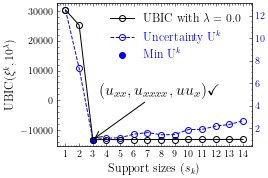

In [39]:
complexity_axis = list(st.track.keys())
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.annotate('$(u_{xx}, u_{xxxx}, uu_{x})\checkmark$', fontsize=16, 
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+15000), 
                 arrowprops={'arrowstyle': '->'})
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(round(last_lam,2))}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper right', fontsize=12)
    
#     fig.savefig("../Figures/KS/ks_ubic_V2.pdf")
#     fig.savefig("tmp.pdf")
    
    plt.show()

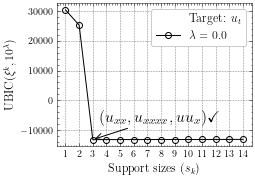

In [37]:
complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $u_t$')
    ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(round(last_lam, 2))}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('$(u_{xx}, u_{xxxx}, uu_{x})\checkmark$', fontsize=16,  
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+6000), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12)
#     fig.savefig("../Figures/KS/ks_ubic.pdf")
    plt.show()
    plt.close()

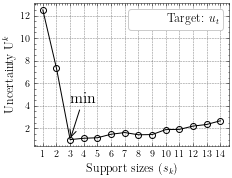

In [38]:
complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $u_t$')
    ax.plot(complexity_axis, b_uns, 'o-', c='black', markerfacecolor='none')
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("Uncertainty $\\textrm{U}^{k}$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('min', fontsize=16, 
                 xy=(complexity_axis[best_bc], b_uns[best_bc]), 
                 xytext=(complexity_axis[best_bc], b_uns[best_bc]+3.25), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12)
#     fig.savefig("../Figures/KS/ks_uns.pdf")
    plt.show()
    plt.close()

['X_pre', 'best_subsets', 'un', 'y_pre']


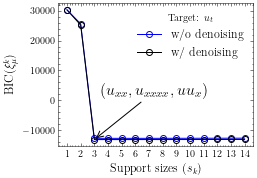

In [39]:
ud_X, un_best_subsets, _, ud_y = h5file("./IPI_output_files/PMS_undenoised_data.h5", 'r')
_, ud_bics, _ = baye_uncertainties([np.where(e>0)[0].tolist() for e in un_best_subsets], 
                                   (ud_X, ud_y), u_type='cv1', take_sqrt=True)

complexity_axis = list(st.track.keys())
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax.plot(complexity_axis, ud_bics, 'o-', c='blue', markerfacecolor='none', label="w/o denoising")
    ax.plot(complexity_axis, b_bics, 'o-', c='black', markerfacecolor='none', label="w/ denoising")
    ax.fill_between(complexity_axis, ud_bics, b_bics, facecolor='blue', alpha=0.1)
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{BIC}(\\xi^{k}_{\\mu})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate(f"$({', '.join(eff_feature_names[np.argmin(b_bics)])})$", fontsize=16, 
                 xy=(complexity_axis[np.argmin(b_bics)], b_bics[np.argmin(b_bics)]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+15000), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12, title='Target: $u_t$')
    fig.savefig("../Figures/KS/ks_bic_V2.pdf")
    plt.show()
    plt.close()

In [28]:
diff_lib = ps.PDELibrary(library_functions=library_functions, 
                         function_names=library_function_names, 
                         derivative_order=4, 
                         spatial_grid=x, 
                         is_uniform=True, 
                         differentiation_method=differentiation_method, 
                         differentiation_kwargs=differentiation_kwargs)

candidate_lib = diff_lib.fit_transform(np.expand_dims(un[:, :], -1))
f_candidate_lib = np.stack([np.fft.fft2(candidate_lib[:, :, i]) 
                            for i in range(candidate_lib.shape[-1])], axis=-1)
candidate_lib = candidate_lib.reshape(-1, candidate_lib.shape[-1])
dynamics = diff_lib.differentiation_method(**diff_lib.differentiation_kwargs, 
                                           axis=1)._differentiate(un[:, :], 
                                                                  t)
f_dynamics = np.fft.fft2(dynamics)
dynamics = dynamics.reshape(-1,1)

dependent = "temporal"
Theta_grouped, Ut_grouped = spatial_temporal_group(candidate_lib, dynamics, 
                                                   (len(x), len(t)), 
                                                   dependent=dependent)

com2coeff = {}
com2paracoeff = {}
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    paracoeff = np.zeros(shape=(candidate_lib.shape[-1], len(Theta_grouped)))
    
    paracoeff[list(indices)] = np.hstack([np.linalg.lstsq(Theta_grouped[_][:, indices], 
                                                          Ut_grouped[_], 
                                                          rcond=None)[0] for _ in range(len(Theta_grouped))])
    
    coeff = np.zeros(shape=(candidate_lib.shape[-1], 1))
    coeff[list(indices)] = np.linalg.lstsq(candidate_lib[:, indices], dynamics)[0]
    coeff = np.hstack([coeff for _ in range(len(Theta_grouped))])
    
    com2coeff[com] = coeff
    com2paracoeff[com] = paracoeff

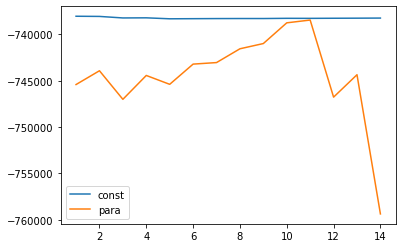

In [29]:
PDE_Losses = np.array([PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2coeff[com])
                       for com in sorted(st.track.keys())])
paraPDE_Losses = np.array([PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2paracoeff[com], const_coeff=False)
                       for com in sorted(st.track.keys())])

### decide whether you are dealing with functional coefficients here ###
plt.plot(sorted(st.track.keys()), PDE_Losses, label='const')
plt.plot(sorted(st.track.keys()), paraPDE_Losses, label='para')
plt.legend()
plt.show()

0.028612395160364457


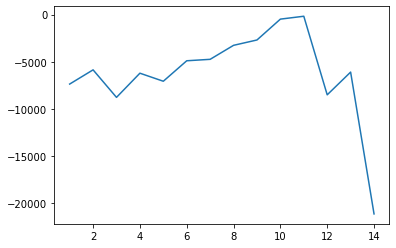

In [30]:
# 5 to 10 percent as threshold
print(np.min(paraPDE_Losses-PDE_Losses)/PDE_Losses[np.argmin(paraPDE_Losses-PDE_Losses)])
plt.plot(sorted(st.track.keys()), paraPDE_Losses-PDE_Losses)
plt.show()

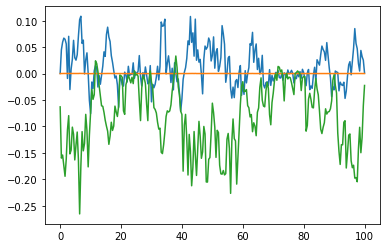

In [31]:
if dependent == "temporal":
    plt.plot(t, com2paracoeff[3][list(st.track[3][0])][0])
    plt.plot(t, com2paracoeff[3][list(st.track[3][0])][1])
    plt.plot(t, com2paracoeff[3][list(st.track[3][0])][2])
elif dependent == "spatial":
    plt.plot(x, com2paracoeff[3][list(st.track[3][0])][0])
    plt.plot(x, com2paracoeff[3][list(st.track[3][0])][1])
    plt.plot(x, com2paracoeff[3][list(st.track[3][0])][2])
plt.show()

In [32]:
maxi = np.max(t); mini = np.min(t)
mid = (mini+maxi)/2
ss = np.arange(0, len(t)-(list(t).index(mid)), dtype=np.int)

com2coeff_sub = {}
for s in ss:
    t_sub_indices = [i+s for i in range(list(t).index(mid)+1)]
    t_sub = t[t_sub_indices]
    un_sub = (un.copy())[:, t_sub_indices]
    print(t_sub_indices[0], "->", t_sub_indices[-1])

    diff_lib = ps.PDELibrary(library_functions=library_functions, 
                             function_names=library_function_names, 
                             derivative_order=4, 
                             spatial_grid=x, 
                             is_uniform=True, 
                             # differentiation_method=differentiation_method, 
                             # differentiation_kwargs=differentiation_kwargs, 
                             differentiation_method=ps.SmoothedFiniteDifference, 
                             differentiation_kwargs={})

    candidate_lib_sub = diff_lib.fit_transform(np.expand_dims(un_sub, -1))
    candidate_lib_sub = candidate_lib_sub.reshape(-1, candidate_lib_sub.shape[-1])
    dynamics_sub = diff_lib.differentiation_method(**diff_lib.differentiation_kwargs, 
                                                   axis=1)._differentiate(un_sub, 
                                                                          t_sub).reshape(-1,1)
    
    Theta_grouped_sub, Ut_grouped_sub = spatial_temporal_group(candidate_lib_sub, dynamics_sub, 
                                                               (len(x), len(t_sub)), 
                                                               dependent=dependent)
    
    for com in sorted(st.track.keys()):
        indices, _ = st.track[com]
        
        coeff = np.hstack([np.linalg.lstsq(Theta_grouped_sub[_][:, indices], 
                                           Ut_grouped_sub[_], 
                                           rcond=None)[0] for _ in range(len(Theta_grouped_sub))])

#         coeff = np.zeros(shape=(candidate_lib_sub.shape[-1], 1))
#         coeff[list(indices)] = np.linalg.lstsq(candidate_lib_sub[:, indices], dynamics_sub)[0]
#         coeff = np.hstack([coeff for _ in range(n)])

        coeff = np.expand_dims(coeff, 0)
        if com not in com2coeff_sub: 
            com2coeff_sub[com] = coeff
        else: 
            com2coeff_sub[com] = np.vstack((com2coeff_sub[com], coeff))

0 -> 125
1 -> 126
2 -> 127
3 -> 128
4 -> 129
5 -> 130
6 -> 131
7 -> 132
8 -> 133
9 -> 134
10 -> 135
11 -> 136
12 -> 137
13 -> 138
14 -> 139
15 -> 140
16 -> 141
17 -> 142
18 -> 143
19 -> 144
20 -> 145
21 -> 146
22 -> 147
23 -> 148
24 -> 149
25 -> 150
26 -> 151
27 -> 152
28 -> 153
29 -> 154
30 -> 155
31 -> 156
32 -> 157
33 -> 158
34 -> 159
35 -> 160
36 -> 161
37 -> 162
38 -> 163
39 -> 164
40 -> 165
41 -> 166
42 -> 167
43 -> 168
44 -> 169
45 -> 170
46 -> 171
47 -> 172
48 -> 173
49 -> 174
50 -> 175
51 -> 176
52 -> 177
53 -> 178
54 -> 179
55 -> 180
56 -> 181
57 -> 182
58 -> 183
59 -> 184
60 -> 185
61 -> 186
62 -> 187
63 -> 188
64 -> 189
65 -> 190
66 -> 191
67 -> 192
68 -> 193
69 -> 194
70 -> 195
71 -> 196
72 -> 197
73 -> 198
74 -> 199
75 -> 200
76 -> 201
77 -> 202
78 -> 203
79 -> 204
80 -> 205
81 -> 206
82 -> 207
83 -> 208
84 -> 209
85 -> 210
86 -> 211
87 -> 212
88 -> 213
89 -> 214
90 -> 215
91 -> 216
92 -> 217
93 -> 218
94 -> 219
95 -> 220
96 -> 221
97 -> 222
98 -> 223
99 -> 224
100 -> 225

In [33]:
cvs = np.zeros((len(st.track.keys()), len(diff_lib.get_feature_names())))
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    cv_com = np.zeros(len(diff_lib.get_feature_names()))
    
    ### treat a seq of coeff values in one horizon as a mean constant number ###
    # mh_coeffs = np.mean(com2coeff_sub[com], axis=-1)
    # cv_com[list(indices)] = np.abs(np.std(mh_coeffs, axis=0)/np.mean(mh_coeffs, axis=0))
    
    ### mean over the horizon axis as well
    cv_com[list(indices)] = np.abs(com2coeff_sub[com].std(axis=0)/com2coeff_sub[com].mean(axis=0)).mean(axis=-1)
    
    cvs[com-1] = cv_com

3


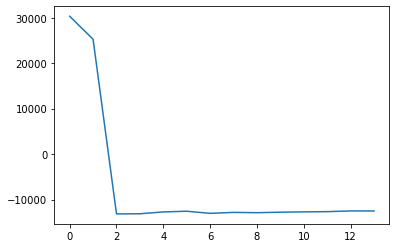

In [34]:
## differentiation_method=differentiation_method (FinDiff package) ##
# [30315.09075333621,
#  25351.16587684649,
#  -13181.30335443969,
#  -13153.817109379948,
#  -12122.27184659524,
#  -13066.395616515074,
#  -13066.766342743485,
#  -12936.06404816712,
#  -12841.68027998799,
#  -12803.01379371767,
#  -12624.815303300396,
#  9626.920897448788,
#  -12340.89249301556,
#  -12358.54348822408]

## differentiation_method=ps.SmoothedFiniteDifference ##
# [30314.301925316086,
#  25249.961044711683,
#  -13157.41655391379,
#  -13123.144773882517,
#  -12721.794958595518,
#  -12567.516845492457,
#  -13030.364646512107,
#  -12823.05298093393,
#  -12888.502335624462,
#  -12779.522068172628,
#  -12708.48948590426,
#  -12661.039768453582,
#  -12501.188745604994,
#  -12515.422967571143]

brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+cvs.sum(axis=-1)[brr_com-1])[0] 
               for brr_pred, brr_com, brr_uncert in brr_bics]
print(np.argmin(brr_bicaics)+1)
plt.plot(brr_bicaics)
plt.show()

#### Unnecessary

In [35]:
maxp = 100 # 10 for aic | 100 for BIC
maxp_step = 0.1
agg_PDE_Losses_cv = []

for p in np.arange(0., maxp+maxp_step, maxp_step):
    PDE_Losses_cv = []
    for com in sorted(st.track.keys()):
        PDE_Loss = PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2coeff[com], 
                                 cv=p*cvs.sum(axis=-1)[com-1], ic_type='bic', version=1)
        PDE_Losses_cv.append(PDE_Loss)
    agg_PDE_Losses_cv.append(PDE_Losses_cv)
# consider min -> max
set(np.argmin(agg_PDE_Losses_cv, axis=-1))

{0, 2, 4}

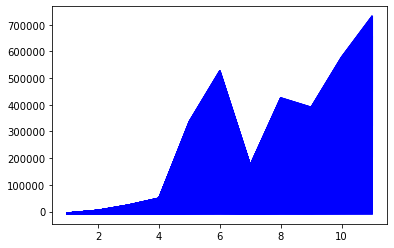

In [36]:
for i in range(len(agg_PDE_Losses_cv)):
    plt.plot([i for i in range(1,15)][:11], agg_PDE_Losses_cv[i][:11], c='blue')
plt.show()

#### Looking at f space (more investigation needed)

In [37]:
from scipy import stats
from scipy.stats import gamma
from scipy.optimize import curve_fit

# FFT stuff
def convert2fspace(sig):
    return np.fft.fftn(sig, s=sig.shape)

def convert2tspace(sig):
    return np.fft.ifft(sig, s=sig.shape)

def cal_psd(sig):
    return (np.abs(sig)**2)/np.prod(sig.shape)

def remove_high_f(f_space, z, mode='gaussian'):
    f_space_clean = f_space.copy()
    psd = cal_psd(f_space_clean)
    upper_bound = -1.0
    if mode == 'gaussian':
        upper_bound = psd.mean()+z*psd.std()
    elif mode == 'tukey':
        q1, q3 = np.percentile(psd, [25, 75])
        upper_bound = q3+z*1e4*(q3-q1)
    f_space_clean[psd>upper_bound] = 0j
    return f_space_clean

3


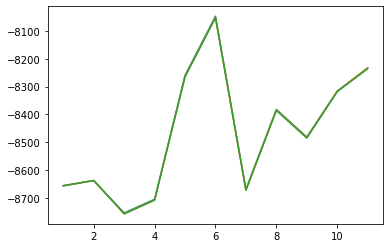

In [38]:
remove_f_mode = 'gaussian'

bic_collections = []
ff_dynamics = f_dynamics.reshape(-1,1)
for kkk in range(3, 6, 1): # or range(3, 11, 3)
    bics = []
    ff_candidate_lib = remove_high_f(f_candidate_lib, kkk, mode=remove_f_mode)
    ff_candidate_lib = ff_candidate_lib.reshape(-1, ff_candidate_lib.shape[-1])
    
    for com in sorted(st.track.keys()):
        indices, _ = st.track[com]
        coeff = np.linalg.lstsq(ff_candidate_lib[:, indices], ff_dynamics)[0]
        pred = candidate_lib[:, indices]@coeff
        bic = BIC_AIC(pred, dynamics, com+cvs.sum(axis=-1)[com-1])[0]
        bics.append(bic)

    bic_collections.append(bics)

print(np.argmin(np.average(bic_collections, axis=0))+1)
for i in range(len(bic_collections)):
    plt.plot(range(1, 15)[:11], bic_collections[i][:11])
plt.show()

In [39]:
# Generate some sample data
data = cal_psd(f_candidate_lib).flatten()

# Define the gamma probability density function (PDF)
def gamma_pdf(x, a, loc, scale):
    return gamma.pdf(x, a, loc, scale)

# Fit the gamma PDF to the normalized histogram of the data using curve_fit
best_mse_fit = 1e6; best_popt = None
for n_bins in range(100, 500, 10):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    try: 
        popt, pcov = curve_fit(gamma_pdf, bin_centers, hist)
        # Extract the fitted parameters
        mse_fit = ((hist-gamma_pdf(bin_centers, *popt))**2).mean()
        if mse_fit < best_mse_fit:
            best_mse_fit = mse_fit
            best_popt = popt
            print(mse_fit, n_bins)
    except RuntimeError:
        pass

9.452988398928427e-16 100


2


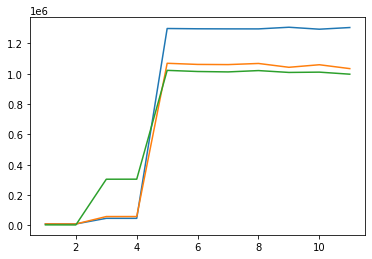

In [40]:
def remove_high_f_dist(f_space, z, dist, best_popt):
    f_space_clean = f_space.copy()
    psd = cal_psd(f_space_clean)
    f_space_clean[dist(psd, *best_popt)<z] = 0j
    return f_space_clean

bic_collections = []
ff_dynamics = f_dynamics.reshape(-1,1)
aaa = 1e-3 # 1e-1, 1e-2, 1e-3
for kkk in [aaa, aaa/1e1, aaa/1e2]:
    bics = []
    ff_candidate_lib = remove_high_f_dist(f_candidate_lib, kkk, gamma.sf, best_popt)
    ff_candidate_lib = ff_candidate_lib.reshape(-1, ff_candidate_lib.shape[-1])
    
    for com in sorted(st.track.keys()):
        indices, _ = st.track[com]
        coeff = np.linalg.lstsq(ff_candidate_lib[:, indices], ff_dynamics)[0]
        pred = candidate_lib[:, indices]@coeff
        # bic = BIC_AIC(pred, dynamics, com)[0]
        bic = BIC_AIC(pred, dynamics, com+cvs.sum(axis=-1)[com-1])[0]
        bics.append(bic)

    bic_collections.append(bics)

print(np.argmin(np.average(bic_collections, axis=0))+1)
for i in range(len(bic_collections)):
    plt.plot(range(1, 15)[:11], bic_collections[i][:11])
plt.show()

In [41]:
raise SystemExit("Stop right here!")

SystemExit: Stop right here!

#### Saving results obtained in IPI step

In [ ]:
best_subsets = sorted([indices for _, (indices, _) in st.track.items()], key=lambda _: len(_))
tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
for i in range(len(best_subsets)):
    tmp[i:i+1, :][0, best_subsets[i]] = 1.0
best_subsets = tmp.astype(np.float32)
del tmp

pms_data = {nameof(un): un, 
            nameof(X_pre): X_pre, 
            nameof(y_pre): y_pre, 
            nameof(best_subsets): best_subsets}
pms_data

In [ ]:
basic_vars = {'u'}
encoded_feature_names = []
for feature in model.get_feature_names():
    out_feature = []
    last_index = -1
    for i, c in enumerate(feature):
        if i+1 < len(feature) and feature[i+1] in basic_vars:
            last_index = i
            out_feature.append(c+'*')
    out_feature.append(feature[last_index+1:])
    encoded_feature_names.append(''.join(out_feature))
encoded_feature_names = np.array(encoded_feature_names)

for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    expr = '+'.join(encoded_feature_names[list(indices)])
    print(expr)
    print('----------')
encoded_pde_names = ['+'.join(encoded_feature_names[list(indices)]) for _, (indices, _) 
                     in sorted(st.track.items())]

In [ ]:
import yaml
from omegaconf import OmegaConf
yml = {}
yml["encoded_feature_names"] = encoded_feature_names.tolist()
yml["encoded_pde_names"] = encoded_pde_names
yml["information_criterion_score"] = [float(ic) for _, (_, ic) in st.track.items()]

In [ ]:
fp1 = "./IPI_output_files/PMS_data.h5"
fp2 = "./IPI_output_files/encoded_pde_names.yaml"

In [ ]:
h5file(file_path=fp1, cdict=pms_data, mode='w')
OmegaConf.save(config=OmegaConf.create(yml), f=fp2)

In [ ]:
OmegaConf.load(fp2)

In [ ]:
h5file(file_path=fp1, mode='r', return_dict=False)

## Denoised weak form

In [42]:
acc=4
# Define the derivative:
d_dx = FinDiff(0, dx, 1, acc=acc)
d_dxx = FinDiff(0, dx, 2, acc=acc)
d_dxxxx = FinDiff(0, dx, 4, acc=acc)
d_dt = FinDiff(1, dt, 1, acc=acc)

coeff = np.linalg.lstsq(np.stack([u*d_dx(u), d_dxx(u), d_dxxxx(u)]).reshape(3, -1).T, 
                        d_dt(u).reshape(-1,1), rcond=None)[0]
print((100*np.abs(coeff+1)).mean())
coeff

0.01072770464374632


array([[-0.99983724],
       [-0.99991587],
       [-0.99992506]])

In [43]:
Xf = np.stack([integrate.trapz(d_dxx(u), t, dt, axis=1), 
               integrate.trapz(d_dxxxx(u), t, dt, axis=1), 
               integrate.trapz(u*d_dx(u), t, dt, axis=1)]).T
yf = integrate.trapz(d_dt(u), t, dt, axis=1).reshape(-1,1)
coeff = np.linalg.lstsq(Xf, yf, rcond=None)[0]
print((100*np.abs(coeff+1)).mean()) # 0.00867587799540844
coeff

0.00867587799540844


array([[-1.00009514],
       [-1.00010748],
       [-1.00005765]])

In [44]:
# sio.savemat("../../PDE_Discovery_Weak_Formulation/Datasets/KS_data_tmp.mat", 
#             {'uu': un, 'xx':x, 'tt':t, 'dx':dx, 'dt': dt})

In [45]:
def weight_poly(x, m, k):
    """
    Polynomial piece of weighting function used to satisfy BC A = d^k/dx^k[(x^2 - 1)^m]
    x: independent variable
    m: power of base function
    k: order of derivative
    """
    a = np.zeros((2*m+1, 1)) # initial coefficient vector
    for l in range(m+1):
        a[2*l] = ((-1)**(m-l))*np.math.comb(m, l) # set polynomial coefficients
    
    c = np.zeros((2*m+1, 1)) # final coefficient vector
    for n in range(2*m-k+1):
        c[n] = a[n+k]*np.math.factorial(n+k)/np.math.factorial(n)
    
    p = 0
    for n in range(2*m-k+1):
        p += c[n]*(x**n) # final windowing function

    return p

def weight_full(k, p, x, t):
    """
    Assemble the 1D weight functions into the full weight
    k = [kx,ky,kt]: order of derivative(s)
    p = [px,py,pt]: exponents of weight polynomials
    """
    if len(k) == 3:
        wx = weight_poly(x, p[0], k[0])
        wy = weight_poly(x, p[1], k[1])
        wt = weight_poly(t, p[2], k[2])
        wX, wY, wT = np.meshgrid(wx, wy, wt)
        W = wX * wY * wT
    elif len(k) == 2:
        wx = weight_poly(x, p[0], k[0])
        wt = weight_poly(t, p[1], k[1])
        wT, wX = np.meshgrid(wt, wx)
        W = wX * wT
    
    return W, wx, wt

In [46]:
# u_weak = un.copy()
# n_domain = 10000
# # x_size, t_size = 2**7, 2**7
# x_size, t_size = 100, 100

# xsup = np.linspace(-1,1,x_size+1)
# tsup = np.linspace(-1,1,t_size+1)
# S_x = 2/(dx*x_size)
# S_t = 2/(dt*t_size)
# delta_x, delta_t = xsup[1]-xsup[0], tsup[1]-tsup[0]

# p = [4,3]
# dA01, _, _ = weight_full([0,1], p, xsup, tsup)
# dA10, _, _ = weight_full([1,0], p, xsup, tsup)
# dA20, _, _ = weight_full([2,0], p, xsup, tsup)
# dA40, _, _ = weight_full([4,0], p, xsup, tsup)

# X_weak = []
# y_weak = []
# # X_weak_romb = []
# # y_weak_romb = []
# for _ in range(n_domain):
#     ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
#     it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
    
#     usup = u_weak[ix, :][:, it]
    
#     f = -(1/2)*(usup**2)*dA10*S_x
#     f1 = trapz(trapz(f, tsup, delta_t, 1), xsup, delta_x, 0)
#     # f11 = romb(romb(f, dt, 1), dx, 0)
    
#     f = usup*dA20*(S_x**2)
#     f2 = trapz(trapz(f, tsup, delta_t, 1), xsup, delta_x, 0)
#     # f22 = romb(romb(f, dt, 1), dx, 0)
    
#     f = usup*dA40*(S_x**4)
#     f3 = trapz(trapz(f, tsup, delta_t, 1), xsup, delta_x, 0)
#     # f33 = romb(romb(f, dt, 1), dx, 0)
    
#     X_weak.append([f1, f2, f3])
#     # X_weak_romb.append([f11, f22, f33])
    
#     f = -usup*dA01*S_t
#     f4 = trapz(trapz(f, tsup, delta_t, 1), xsup, delta_x, 0)
#     # f44 = romb(romb(f, dt, 1), dx, 0)
    
#     y_weak.append(f4)
#     # y_weak_romb.append(f44)
    
# X_weak = np.array(X_weak)
# y_weak = np.array(y_weak)

# coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
# (coeff, (np.abs(coeff+1)*100).mean())

# # X_weak_romb = np.array(X_weak_romb)
# # y_weak_romb = np.array(y_weak_romb)
# # coeff = np.linalg.lstsq(X_weak_romb, y_weak_romb, rcond=None)[0]
# # coeff, (np.abs(coeff+1)*100).mean()

#### Tune orders of xsup, tsup

In [48]:
u_weak = un.copy()
n_domain = 10000
div = 10.5
# x_size, t_size = 100, 100
# x_size, t_size = int(u_weak.shape[0]/div), int(u_weak.shape[1]/div)
x_size, t_size = int(max(u_weak.shape)/div), int(max(u_weak.shape)/div)

xsup = np.linspace(-1,1,x_size+1)
tsup = np.linspace(-1,1,t_size+1)
delta_x = xsup[1]-xsup[0]
delta_t = tsup[1]-tsup[0]
S_x = 2/(dx*x_size)
S_t = 2/(dt*t_size)

max_order = 4
best_loss = 1e6; best_coeff = None
for mo in range(max_order, max_order+10, 1):
    wx, wt = np.meshgrid((xsup**2-1)**(mo), (tsup**2-1)**(mo))
    W = (wx*wt).T
    
    # Define the derivative:
    d_dx = FinDiff(0, xsup[1]-xsup[0], 1)
    d_dxx = FinDiff(0, xsup[1]-xsup[0], 2)
    d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4)
    d_dt = FinDiff(1, tsup[1]-tsup[0], 1)

    dA01 = d_dt(W)
    dA10 = d_dx(W)
    dA20 = d_dxx(W)
    dA40 = d_dxxxx(W)

    X_weak = []
    y_weak = []
    for _ in trange(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)

        usup = (u_weak[ix, :][:, it])

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, delta_t, 1), xsup, delta_x, 0)
        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, delta_t, 1), xsup, delta_x, 0)
        f3 = usup*dA40*(S_x**4)
        f3 = trapz(trapz(f3, tsup, delta_t, 1), xsup, delta_x, 0)
        
        X_weak.append([f1, f2, f3])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, delta_t, 1), xsup, delta_x, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)

    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()

    print(mo)
    print(loss, evaluate_coefficients(coeff))
    if loss < best_loss:
        best_loss = loss
        best_coeff = coeff
    else:
        break
        
best_mo = mo-1
best_coeff, evaluate_coefficients(best_coeff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2359.57it/s]


4
3.798810353078484e-06 (0.23565598589003015, 0.1782262704940523)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2434.87it/s]

5
4.544933503869478e-06 (4.265278639301351, 1.4526052378876313)


(array([-0.99515426, -0.99923107, -1.00145501]),
 (0.23565598589003015, 0.1782262704940523))

In [49]:
bp, bq = best_mo, best_mo
W = np.product(np.meshgrid((xsup**2-1)**(bp), (tsup**2-1)**(bq)), axis=0).T

# Define the derivative:
d_dx = FinDiff(0, xsup[1]-xsup[0], 1)
d_dxx = FinDiff(0, xsup[1]-xsup[0], 2)
d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4)
d_dt = FinDiff(1, tsup[1]-tsup[0], 1)

dA01 = d_dt(W)
dA10 = d_dx(W)
dA20 = d_dxx(W)
dA40 = d_dxxxx(W)

#### Denoised weak form (Savgol V2)

In [50]:
min_loss = 1e6; best_coeff = None
for ws in trange(3, 33, 2):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = savgol_filter(u_weak[ix, :][:, it], ws, 2)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, dt, 1), xsup, dx, 0)
        # f1 = romb(romb(f1, dt, 1), dx, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, dt, 1), xsup, dx, 0)
        # f2 = romb(romb(f2, dt, 1), dx, 0)

        f3 = usup*dA40*(S_x**4)
        f3 = trapz(trapz(f3, tsup, dt, 1), xsup, dx, 0)
        # f3 = romb(romb(f3, dt, 1), dx, 0)

        X_weak.append([f1, f2, f3])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, dt, 1), xsup, dx, 0)
        # f4 = romb(romb(f4, dt, 1), dx, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# Maybe do simulation next?
min_loss, best_coeff, (np.abs(best_coeff+1)*100).mean() # Nice result (0.29497065338643935)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:18<00:00,  9.23s/it]


(3.6041134086155883e-06,
 array([-0.99358236, -0.99768009, -1.00011157]),
 0.29497065338643935)

In [52]:
step = 0.01
hyperparameter_val_range = np.arange(step, 1, step)
min_loss = 1e6; best_coeff = None
for hyperparameter_val in tqdm(hyperparameter_val_range):
    X_weak = []
    y_weak = []
    denoise_u_weak = filtfilt(*butter(2, hyperparameter_val), u_weak)
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = denoise_u_weak[ix, :][:, it]

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, dt, 1), xsup, dx, 0)
        # f1 = romb(romb(f1, dt, 1), dx, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, dt, 1), xsup, dx, 0)
        # f2 = romb(romb(f2, dt, 1), dx, 0)

        f3 = usup*dA40*(S_x**4)
        f3 = trapz(trapz(f3, tsup, dt, 1), xsup, dx, 0)
        # f3 = romb(romb(f3, dt, 1), dx, 0)

        X_weak.append([f1, f2, f3])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, dt, 1), xsup, dx, 0)
        # f4 = romb(romb(f4, dt, 1), dx, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# Maybe do simulation next?
min_loss, best_coeff, (np.abs(best_coeff+1)*100).mean() # Nice result (0.31068650078021803)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [07:17<00:00,  4.41s/it]


(3.5918779777102595e-06,
 array([-0.992457  , -0.99677351, -0.99922568]),
 0.3847936368267857)

#### Denoised weak form (Wiener, Current best)

In [53]:
min_loss = 1e6; best_coeff = None
for ws in trange(3, 33, 1):
    X_weak = []
    y_weak = []
    
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = wiener(u_weak[ix, :][:, it], ws)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, dt, 1), xsup, dx, 0)
        # f1 = romb(romb(f1, dt, 1), dx, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, dt, 1), xsup, dx, 0)
        # f2 = romb(romb(f2, dt, 1), dx, 0)

        f3 = usup*dA40*(S_x**4)
        f3 = trapz(trapz(f3, tsup, dt, 1), xsup, dx, 0)
        # f3 = romb(romb(f3, dt, 1), dx, 0)

        X_weak.append([f1, f2, f3])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, dt, 1), xsup, dx, 0)
        # f4 = romb(romb(f4, dt, 1), dx, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# Maybe do simulation next?
# Nice result 0.1896211378363081
min_loss, best_coeff, (np.abs(best_coeff+1)*100).mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [06:28<00:00, 12.94s/it]


(3.921240038596496e-06,
 array([-0.99904037, -0.99858177, -1.00331077]),
 0.1896211378363081)